## Observations and Insights 

In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st

# Study data files
mouse_metadata_path = "Resources/mouse_metadata.csv"
study_results_path = "Resources/study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)
print(mouse_metadata.columns)
print(study_results.columns)

Index(['Mouse ID', 'Drug Regimen', 'Sex', 'Age_months', 'Weight (g)'], dtype='object')
Index(['Mouse ID', 'Timepoint', 'Tumor Volume (mm3)', 'Metastatic Sites'], dtype='object')


In [3]:
# Combine the data into a single dataset
combined_data_raw = pd.merge(mouse_metadata, study_results, on="Mouse ID", how="outer")
# Display the data table for preview
combined_data_raw

Mouse ID Drug Regimen   Sex  Age_months  Weight (g)  Timepoint  \
0        k403     Ramicane  Male          21          16          0   
1        k403     Ramicane  Male          21          16          5   
2        k403     Ramicane  Male          21          16         10   
3        k403     Ramicane  Male          21          16         15   
4        k403     Ramicane  Male          21          16         20   
...       ...          ...   ...         ...         ...        ...   
1888     z969     Naftisol  Male           9          30         25   
1889     z969     Naftisol  Male           9          30         30   
1890     z969     Naftisol  Male           9          30         35   
1891     z969     Naftisol  Male           9          30         40   
1892     z969     Naftisol  Male           9          30         45   

      Tumor Volume (mm3)  Metastatic Sites  
0              45.000000                 0  
1              38.825898                 0  
2              35.014271                 1  
3              34.223992                 1  
4              32.997729                 1  
...                  ...               ...  
1888           63.145652                 2  
1889           65.841013                 3  
1890           69.176246                 4  
1891           70.314904                 4  
1892           73.867845                 4  

[1893 rows x 8 columns]

In [4]:
# Stores all of the Box Plot numbers
def getBoxPlotNums(df):
    d = {}
    quartiles = df["Tumor Volume (mm3)"].quantile([.25,.5,.75])
    d["Lower Qrt"] = quartiles[0.25]
    d["Upper Qrt"] = quartiles[0.75]
    d["IQR"] = d["Upper Qrt"]-d["Lower Qrt"]
    d["Lower Bound"] = d["Lower Qrt"] - (1.5*d["IQR"])
    d["Upper Bound"] = d["Upper Qrt"] + (1.5*d["IQR"])
    return d

In [5]:
def getOutliers(df,calcs):
    low_out = df.loc[df["Tumor Volume (mm3)"] < calcs["Lower Bound"],]
    upp_out = df.loc[df["Tumor Volume (mm3)"] > calcs["Upper Bound"],]
    return [pd.merge(low_out,upp_out,how="outer")["Mouse ID"].values,pd.merge(low_out,upp_out,how="outer")["Tumor Volume (mm3)"].values]

In [6]:
# Checking the number of mice.
mice_unique = combined_data_raw["Mouse ID"].unique()
len(mice_unique)

249

In [7]:
# Removing the duplicate rows that shows up for Mouse ID and Timepoint.
combined_data_raw["Dupe?"] = combined_data_raw.duplicated(subset=["Mouse ID","Timepoint"],keep=False)
duped_mouse = combined_data_raw.loc[combined_data_raw["Dupe?"] == True,]["Mouse ID"]
duped_mouse = duped_mouse.unique()[0]
combined_data = combined_data_raw.loc[combined_data_raw["Mouse ID"] != duped_mouse,]
combined_data = combined_data.drop(columns="Dupe?")
combined_data

Mouse ID Drug Regimen   Sex  Age_months  Weight (g)  Timepoint  \
0        k403     Ramicane  Male          21          16          0   
1        k403     Ramicane  Male          21          16          5   
2        k403     Ramicane  Male          21          16         10   
3        k403     Ramicane  Male          21          16         15   
4        k403     Ramicane  Male          21          16         20   
...       ...          ...   ...         ...         ...        ...   
1888     z969     Naftisol  Male           9          30         25   
1889     z969     Naftisol  Male           9          30         30   
1890     z969     Naftisol  Male           9          30         35   
1891     z969     Naftisol  Male           9          30         40   
1892     z969     Naftisol  Male           9          30         45   

      Tumor Volume (mm3)  Metastatic Sites  
0              45.000000                 0  
1              38.825898                 0  
2              35.014271                 1  
3              34.223992                 1  
4              32.997729                 1  
...                  ...               ...  
1888           63.145652                 2  
1889           65.841013                 3  
1890           69.176246                 4  
1891           70.314904                 4  
1892           73.867845                 4  

[1880 rows x 8 columns]

In [8]:
# Optional: Get all the data for the duplicate mouse ID. 
mice_timepoint_data = {}
for mouse in mice_unique:
    mice_timepoint_data[mouse] = combined_data.loc[combined_data["Mouse ID"] == mouse,]

mice_timepoint_data

{'k403':   Mouse ID Drug Regimen   Sex  Age_months  Weight (g)  Timepoint  \
 0     k403     Ramicane  Male          21          16          0   
 1     k403     Ramicane  Male          21          16          5   
 2     k403     Ramicane  Male          21          16         10   
 3     k403     Ramicane  Male          21          16         15   
 4     k403     Ramicane  Male          21          16         20   
 5     k403     Ramicane  Male          21          16         25   
 6     k403     Ramicane  Male          21          16         30   
 7     k403     Ramicane  Male          21          16         35   
 8     k403     Ramicane  Male          21          16         40   
 9     k403     Ramicane  Male          21          16         45   
 
    Tumor Volume (mm3)  Metastatic Sites  
 0           45.000000                 0  
 1           38.825898                 0  
 2           35.014271                 1  
 3           34.223992                 1  
 4           32.

In [9]:
# Checking the number of mice in the clean DataFrame.
mice_unique_df = combined_data.groupby("Mouse ID")
mice_count = mice_unique_df["Mouse ID"].unique()
len(mice_count)

248

## Summary Statistics

In [10]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# Use groupby and summary statistical methods to calculate the following properties of each drug regimen: 
# mean, median, variance, standard deviation, and SEM of the tumor volume. 
# Assemble the resulting series into a single summary dataframe.
grouped_drug = combined_data.groupby("Drug Regimen")["Tumor Volume (mm3)"]
compare_drug_tumor = pd.DataFrame({})
compare_drug_tumor["Mean"] = grouped_drug.mean()
compare_drug_tumor["Median"] = grouped_drug.median()
compare_drug_tumor["Variance"] = grouped_drug.var()
compare_drug_tumor["Std Dev"] = grouped_drug.std()
compare_drug_tumor["Std Error"] = grouped_drug.sem()
compare_drug_tumor


Mean     Median   Variance   Std Dev  Std Error
Drug Regimen                                                      
Capomulin     40.675741  41.557809  24.947764  4.994774   0.329346
Ceftamin      52.591172  51.776157  39.290177  6.268188   0.469821
Infubinol     52.884795  51.820584  43.128684  6.567243   0.492236
Ketapril      55.235638  53.698743  68.553577  8.279709   0.603860
Naftisol      54.331565  52.509285  66.173479  8.134708   0.596466
Placebo       54.033581  52.288934  61.168083  7.821003   0.581331
Propriva      52.320930  50.446266  43.852013  6.622085   0.544332
Ramicane      40.216745  40.673236  23.486704  4.846308   0.320955
Stelasyn      54.233149  52.431737  59.450562  7.710419   0.573111
Zoniferol     53.236507  51.818479  48.533355  6.966589   0.516398

In [11]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# Using the aggregation method, produce the same summary statistics in a single line
summary_df = pd.DataFrame({})
summary_df["Summary of Drug Regimen"] = compare_drug_tumor.aggregate({"Mean": "mean",
                             "Median": "mean",
                             "Variance": "mean",
                             "Std Dev": "mean",
                             "Std Error": "mean"})
summary_df

Summary of Drug Regimen
Mean                     50.975982
Median                   49.902123
Variance                 47.858440
Std Dev                   6.821103
Std Error                 0.502785

## Bar and Pie Charts

In [12]:
# Generate a bar plot showing the total number of measurements taken on each drug regimen using pandas.
tests_per_drug = combined_data.groupby("Drug Regimen")["Timepoint"].count()
tests_per_drug

Drug Regimen
Capomulin    230
Ceftamin     178
Infubinol    178
Ketapril     188
Naftisol     186
Placebo      181
Propriva     148
Ramicane     228
Stelasyn     181
Zoniferol    182
Name: Timepoint, dtype: int64

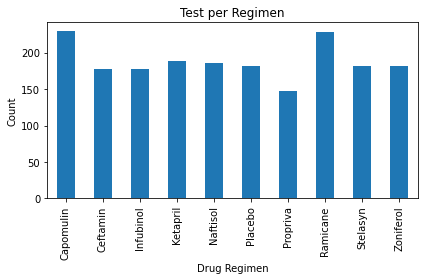

In [13]:
# Generate a bar plot showing the total number of measurements taken on each drug regimen using pyplot.
tests_per_drug_plt = tests_per_drug.plot(kind="bar")
tests_per_drug_plt.set_title("Test per Regimen")
tests_per_drug_plt.set_xlabel("Drug Regimen")
tests_per_drug_plt.set_ylabel("Count")
plt.tight_layout()

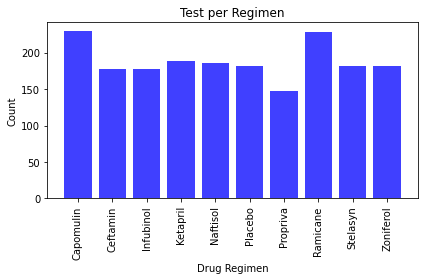

In [14]:
# Generate a bar plot showing the total number of measurements taken on each drug regimen using pyplot.
x_axis = tests_per_drug.index
y_axis = tests_per_drug.values
plt.bar(x_axis,y_axis,color='blue',alpha=.75)
plt.xticks(rotation=90)
plt.title("Test per Regimen")
plt.xlabel("Drug Regimen")
plt.ylabel("Count")
plt.tight_layout()

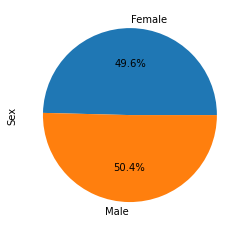

In [15]:
# Generate a pie plot showing the distribution of female versus male mice using pandas
combined_gender = combined_data.drop_duplicates("Mouse ID")
combined_gender = combined_gender.groupby("Sex")["Sex"].count()
gender_plt = combined_gender.plot(kind="pie", autopct="%1.1f%%")

([<matplotlib.patches.Wedge at 0x2586de87c10>,
 [Text(0.013934097579311265, 1.0999117423341975, 'Female'),
  Text(-0.0139340975793114, -1.0999117423341975, 'Male')],
 [Text(0.007600416861442507, 0.5999518594550168, '49.6%'),
  Text(-0.007600416861442581, -0.5999518594550168, '50.4%')])

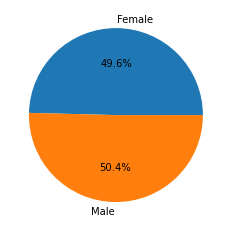

In [16]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot
x_axis = combined_gender.values
labels = combined_gender.index
plt.pie(x=x_axis, labels=labels, autopct="%1.1f%%")

## Quartiles, Outliers and Boxplots

In [17]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin
# Start by getting the last (greatest) timepoint for each mouse
ending_tumor_size_df = combined_data.sort_values(by=["Mouse ID","Timepoint"])
ending_tumor_size_df = ending_tumor_size_df.drop_duplicates("Mouse ID", keep="last", ignore_index=True)

In [18]:
# Put treatments into a list for for loop (and later for plot labels)
drug_labels = ["Capomulin", "Ramicane", "Infubinol", "Ceftamin"]

# Create empty list to fill with tumor vol data (for plotting)
tumor_data_list = []
    
# Locate the rows which contain mice on each drug and get the tumor volumes
capomulin_data = ending_tumor_size_df.loc[ending_tumor_size_df["Drug Regimen"] == "Capomulin",]
ramicane_data = ending_tumor_size_df.loc[ending_tumor_size_df["Drug Regimen"] == "Ramicane",]
infubinol_data = ending_tumor_size_df.loc[ending_tumor_size_df["Drug Regimen"] == "Infubinol",]
ceftamin_data = ending_tumor_size_df.loc[ending_tumor_size_df["Drug Regimen"] == "Ceftamin",]
drug_subset = [capomulin_data["Tumor Volume (mm3)"],ramicane_data["Tumor Volume (mm3)"],infubinol_data["Tumor Volume (mm3)"],ceftamin_data["Tumor Volume (mm3)"]]

# Calculate the IQR and quantitatively determine if there are any potential outliers. 
capomulin_calcs = getBoxPlotNums(capomulin_data)
ramicane_calcs = getBoxPlotNums(ramicane_data)
infubinol_calcs = getBoxPlotNums(infubinol_data)
ceftamin_calcs = getBoxPlotNums(ceftamin_data)


# Determine outliers using upper and lower bounds
capomulin_outliers = getOutliers(capomulin_data,capomulin_calcs)
ramicane_outliers = getOutliers(ramicane_data,ramicane_calcs)
infubinol_outliers = getOutliers(infubinol_data,infubinol_calcs)
ceftamin_outliers = getOutliers(ceftamin_data,ceftamin_calcs)
print(f"Capomulin: {capomulin_outliers}")
print(f"Ramicane: {ramicane_outliers}")
print(f"Infubinol: {infubinol_outliers}")
print(f"Ceftamin: {ceftamin_outliers}")

Capomulin: [array([], dtype=object), array([], dtype=float64)]
Ramicane: [array([], dtype=object), array([], dtype=float64)]
Infubinol: [array(['c326'], dtype=object), array([36.3213458])]
Ceftamin: [array([], dtype=object), array([], dtype=float64)]


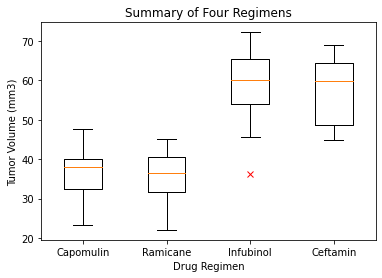

In [31]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest
fig, ax = plt.subplots()
outlier_format = dict(markeredgecolor="r", marker="x")
ax.boxplot(drug_subset, labels=drug_labels, flierprops=outlier_format)
plt.title("Summary of Four Regimens")
plt.xlabel("Drug Regimen")
plt.ylabel("Tumor Volume (mm3)")
plt.show()

## Line and Scatter Plots

Text(0, 0.5, 'Tumor Volume (mm3)')

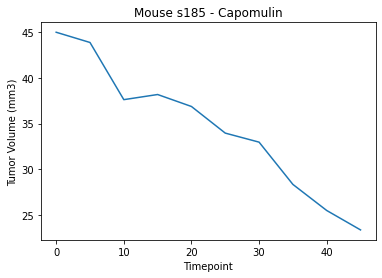

In [70]:
# Generate a line plot of tumor volume vs. time point for a mouse treated with Capomulin
mouse_s185_df = combined_data.loc[combined_data["Mouse ID"]=="s185",]
x = "Timepoint"
y = "Tumor Volume (mm3)"
title = "Mouse s185 - Capomulin"
mouse_s185_plt = mouse_s185_df.plot(x=x, y=y, kind="line", title=title, legend=False)
mouse_s185_plt.set_ylabel("Tumor Volume (mm3)")


AttributeError: 'PathCollection' object has no property 'title'

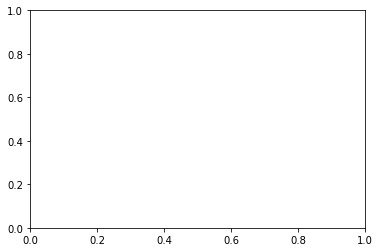

In [78]:
# Generate a scatter plot of average tumor volume vs. mouse weight for the Capomulin regimen
capomulin_raw_data = combined_data.loc[combined_data["Drug Regimen"] == "Capomulin",]
x = capomulin_raw_data.groupby("Mouse ID")["Weight (g)"].mean().values
y = capomulin_raw_data.groupby("Mouse ID")["Tumor Volume (mm3)"].mean().values
plt.scatter(x=x,y=y)
plt.title("Capomulin: Avg. Tumor Vol vs. Weight")
x_label = ("Weight (g)")
y_label = "Tumor Volume (mm3)"

## Correlation and Regression

In [22]:
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen
